In [1]:
import numpy as np
import tarfile
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Important for the import of cifar 10
import sys
sys.path.append("../")
from dataloader import load_cifar10
from dataloader import load_mnist



#### **The point of this notebook, is to show the progress of building a FFN from sratch, that means each section will add a new functionality, so it will become a step-by-step progress. We have derived formulas and ideas in each section aswell**

# Section 1: Dataloading + one-hot

### Load the cifar-10

In [2]:
# Load CIFAR-10
#X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../data/cifar-10-python.tar.gz")
# Load MNIST
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist("/workspaces/02456-deep-learning/data/mnist")

### THE SHAPE OF CIFAR IS:    (RxGxB = 3) x 32 x 32       x      (no. pictures)

Train set: (54000, 1, 28, 28) (54000,)
Validation set: (6000, 1, 28, 28) (6000,)
Test set: (10000, 1, 28, 28) (10000,)


In [3]:
X_flat = X_train.reshape(X_train.shape[0], -1)  # (54000, 784)
X_flat = X_flat 
X_flat.shape

(54000, 784)

So the input for each picture will be: 1 * 28 * 28 = 784

In [4]:
X_train[0].shape

(1, 28, 28)

In [5]:
ex = X_train[0].flatten()
ex.shape

(784,)

> Perform one hot encoding on the training labels

In [6]:

num_classes = y_train.max() + 1

# Convert to one-hot encoding
y_train_onehot = np.eye(num_classes)[y_train]

print(y_train_onehot[0], y_train[0])


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 6


# Section 2: FFN

> ### Forward method of layer 

In [7]:
def activation(activationName, Z):
    if activationName == "RELU":
        return np.maximum(0, Z)
    
    if activationName == "Softmax":
        # x: (batch_size, n_classes)
        x_shifted = Z - np.max(Z, axis=-1, keepdims=True)
        e_x = np.exp(x_shifted)
        return e_x / e_x.sum(axis=-1, keepdims=True)

def activation_derivative(activationName, Z):
    if activationName == "RELU":
        return (Z > 0).astype(float)  # 1 where Z > 0, else 0
    # add more derivatives if needed


In [8]:
class Layer:
    def __init__(self, input_dim, output_dim, activation = "RELU"):
        print(f'Layer with input_dim: {input_dim}, output dim, {output_dim}')
        self.inp = input_dim
        self.out = output_dim
        self.activation = activation

        self.a = None
        self.z = None
        
        #HE init of weights (refer to lecture notes)
        self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
        self.b = np.zeros(output_dim)  

    
    #This forward will either calculate for a single vector (z) or a batch
    def forward(self, z):
            # z can be (input_dim,) or (batch_size, input_dim)
        self.a = z @ self.W + self.b  # (batch_size, output_dim)
        self.z = activation(self.activation, self.a)
        return self.z



In [9]:
layer1 = Layer(784, 128, "RELU")
output = Layer(128, 10, "Softmax")

layer1.forward(X_flat)
output.forward(layer1.z)

output.z[1]



Layer with input_dim: 784, output dim, 128
Layer with input_dim: 128, output dim, 10


array([9.26228833e-075, 1.00000000e+000, 3.47531790e-101, 8.07790580e-177,
       5.06411691e-149, 1.01654742e-056, 1.90836427e-203, 5.18013056e-045,
       6.51934873e-060, 9.95458966e-178])

In [10]:
output.z

array([[1.00000000e+000, 3.38913047e-029, 8.20512482e-031, ...,
        9.92198486e-034, 1.42159668e-053, 1.37282717e-132],
       [9.26228833e-075, 1.00000000e+000, 3.47531790e-101, ...,
        5.18013056e-045, 6.51934873e-060, 9.95458966e-178],
       [1.00000000e+000, 1.79625093e-032, 1.27938205e-086, ...,
        8.81970039e-065, 9.17026888e-031, 4.66192568e-085],
       ...,
       [1.00000000e+000, 2.31914597e-082, 1.57175450e-024, ...,
        1.48078817e-040, 1.67831730e-183, 1.96636265e-078],
       [2.75910381e-086, 1.00000000e+000, 1.04687182e-117, ...,
        8.94848871e-155, 2.59894700e-146, 1.29391867e-137],
       [7.34264750e-068, 1.00000000e+000, 4.28691873e-145, ...,
        1.00347677e-048, 3.67869867e-076, 3.06591803e-106]],
      shape=(54000, 10))

> ### Forward method of layer + loss 

We are not getting a output, we are purely working with multi-class classfication, therefore we will use cross-entropy as a loss function. In order for us to calculate cross entropy loss

1. We are getting a probability density as output
2. onehot(score) gives a 10 x [0,0,0,0,0,1,0,0] of different combinations depending on label
3. We then say loss(onehot(score), y_true) for each output

> Source :  https://medium.com/@naqvishahwar120/ai-using-cross-entropy-loss-function-and-one-hot-encoding-4a102a1253dc

We will be implementing cross entropy (numerical stable version from lecture)

In [11]:

eps = 1e-15
probs = np.clip(output.z, eps, 1 - eps)
loss = -np.sum(y_train_onehot * np.log(probs)) / y_train_onehot.shape[0]


print("Cross Entropy Loss:", loss)


Cross Entropy Loss: 32.45624620420152


> ### Forward method of layer + loss + Manual backpropagation

1. We are working with multi-classification, so the only last layer activation function will be softmax
2. We want to be able to use cross-entropy loss function

>Source: https://www.parasdahal.com/softmax-crossentropy

>Source: https://www.kaggle.com/code/ravaghi/neural-networks-from-scratch-using-only-numpy

> Overall method : Calcuate output gradient using Softmax / Cross entropy





#### 1. Output layer

The output logits:

$$
o_k = \sum_i w^{(L)}_{ki}\, z^{(L-1)}_i + b^{(L)}_k
$$

Softmax probabilities:

$$
p_i = \frac{e^{o_i}}{\sum_k e^{o_k}}
$$

Cross-entropy loss:

$$
L(\mathbf{y}, \mathbf{p}) = - \sum_k y_k \log(p_k)
$$

Derivative of softmax + cross-entropy:

$$
\frac{\partial L}{\partial o_i} = p_i - y_i
$$

Define the **output delta**:

$$
\delta^{(L)}_i = p_i - y_i
$$

Weight and bias gradients:

$$
\frac{\partial L}{\partial w^{(L)}_{ji}} = \delta^{(L)}_j \, z^{(L-1)}_i, 
\qquad
\frac{\partial L}{\partial b^{(L)}_j} = \delta^{(L)}_j
$$

---

#### 2. Hidden layers (l = L-1, ..., 1)

For hidden layer \(l\) with pre-activation \(a^{(l)}_j\) and post-activation \(z^{(l)}_j = h_l(a^{(l)}_j)\):

Hidden delta:

$$
\delta^{(l)}_j = h_l'(a^{(l)}_j) \sum_{k=1}^{K_{l+1}} w^{(l+1)}_{kj} \, \delta^{(l+1)}_k
$$

Weight and bias gradients:

$$
\frac{\partial L}{\partial w^{(l)}_{ji}} = \delta^{(l)}_j \, z^{(l-1)}_i, 
\qquad
\frac{\partial L}{\partial b^{(l)}_j} = \delta^{(l)}_j
$$


#### 3. Summary table

$$
\begin{align}
\text{Output layer:} \quad & 
\frac{\partial L}{\partial w^{(L)}_{ji}} = \delta^{(L)}_j \, z^{(L-1)}_i, \quad
\frac{\partial L}{\partial b^{(L)}_j} = \delta^{(L)}_j, \quad
\delta^{(L)}_j = p_j - y_j \\
\text{Hidden layer:} \quad & 
\frac{\partial L}{\partial w^{(l)}_{ji}} = \delta^{(l)}_j \, z^{(l-1)}_i, \quad
\frac{\partial L}{\partial b^{(l)}_j} = \delta^{(l)}_j, \quad
\delta^{(l)}_j = h_l'(a^{(l)}_j) \sum_{k=1}^{K_{l+1}} w^{(l+1)}_{kj} \, \delta^{(l+1)}_k
\end{align}
$$




Manual backprop of 2 layer FFN

In [12]:
X_flat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(54000, 784), dtype=uint8)

In [13]:
output.z[0]
print("Cross Entropy Loss before gradient descent:", loss)

Cross Entropy Loss before gradient descent: 32.45624620420152


In [14]:
loss_list = []
accuracy_list = []

learning_rate = 0.01
m = X_flat.shape[0]

for i in range(5):
    z1 = layer1.forward(X_flat)
    z2 = output.forward(z1)

    delta2 = z2 - y_train_onehot
    dW2 = z1.T @ delta2 / m
    db2 = np.sum(delta2, axis=0) / m

    delta1 = delta2 @ output.W.T * activation_derivative("RELU", layer1.a)
    dW1 = X_flat.T @ delta1 / m
    db1 = np.sum(delta1, axis=0) / m

    layer1.W -= learning_rate * dW1
    layer1.b -= learning_rate * db1
    output.W -= learning_rate * dW2
    output.b -= learning_rate * db2

    eps = 1e-15
    probs = np.clip(z2, eps, 1 - eps)
    loss = -np.sum(y_train_onehot * np.log(probs)) / m
    loss_list.append(loss)

    y_pred = np.argmax(z2, axis=1)
    y_true = np.argmax(y_train_onehot, axis=1)
    acc = np.mean(y_pred == y_true)
    accuracy_list.append(acc)

    #print(f"Iteration {i+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

print("Cross Entropy Loss after gradient descent:", loss)


Cross Entropy Loss after gradient descent: 29.97465650055659


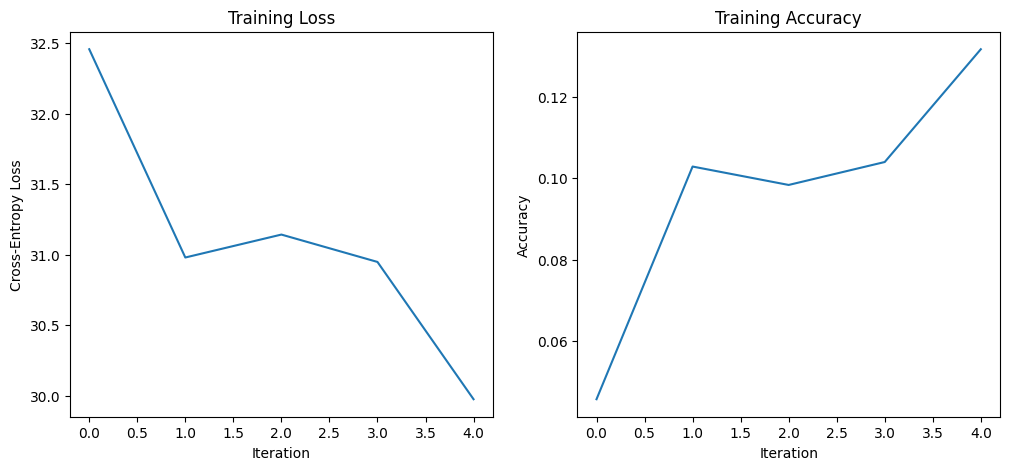

Final Loss: 29.97465650055659
Final Accuracy: 0.13164814814814815


In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(accuracy_list)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

print("Final Loss:", loss_list[-1])
print("Final Accuracy:", accuracy_list[-1])

> **Part conclusion** We are able to see that the cross-entropy-loss is decreasing as we run the gradients and forward measures again, again and again, therefore we can create a loop for this. (called backprop). This will perform the gradient descent

> ### Forward method of layer + loss + modular backpropagation

This will be a VERY simple NN architecture, in which we will build upon. 

In [16]:
def activation(name, x):
    if name == "RELU":
        return np.maximum(0, x)
    elif name == "Softmax":
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)


def activation_derivative(activationName, Z):
    if activationName == "RELU":
        return (Z > 0).astype(float) 



In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss = None

    def returnLoss(self, y_true):
        # y_true is one-hot
        z = self.layers[-1].z
        eps = 1e-15  # avoid log(0)
        return -np.mean(np.sum(y_true * np.log(z + eps), axis=1))


    def linearLayer(self, input_dim, output_dim, activation = "RELU"):
        self.layers.append(Layer(input_dim, output_dim, activation))

    def Forward(self, input):
        #First we calculate the input 
        self.layers[0].forward(input)

        #Then we use the input z, to calculte subsquent layers
        for i in range(1, len(self.layers)):
            self.layers[i].forward(self.layers[i-1].z)

        #Output the output after softmax, this will be a distribution
        #debug 
        #print(self.layers[-1].z[0])

    def backward(self, X_train, y_train_onehot, lr=0.01, optimizer="SGD"):
        m = X_train.shape[0]

        # ---------- Output layer ----------
        output_layer = self.layers[-1]
        delta = output_layer.z - y_train_onehot  # (B, output_dim)
        prev_activation = self.layers[-2].z  # activation from previous layer
        output_layer.dW = prev_activation.T @ delta / m
        output_layer.db = np.sum(delta, axis=0) / m

        # ---------- Hidden layers ----------
        # Backprop through layers in reverse order (excluding output)
        for i in reversed(range(len(self.layers)-1)):
            layer = self.layers[i]

            if i == 0:
                # Input to the first layer is X_train
                input_activation = X_train
            else:
                # activation from previous hidden layer
                input_activation = self.layers[i-1].z  
            next_layer = self.layers[i+1]

            # delta for current layer
            delta = (delta @ next_layer.W.T) * activation_derivative("RELU", layer.z)

            layer.dW = input_activation.T @ delta / m
            layer.db = np.sum(delta, axis=0) / m

        # ---------- Update parameters ----------
        for layer in self.layers:
            if optimizer == "SGD":
                layer.W -= lr * layer.dW
                layer.b -= lr * layer.db




                    

In [18]:
class Layer:
    def __init__(self, input_dim, output_dim, activation = "RELU"):
        print(f'Layer with input_dim: {input_dim}, output dim, {output_dim}')
        self.inp = input_dim
        self.out = output_dim
        self.activation = activation

        self.a = None
        self.z = None
        
        if self.activation == "RELU":
            # He initialization for ReLU
            self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
        else:
            # Small initialization for softmax layer
            self.W = np.random.randn(input_dim, output_dim) * 0.01
        self.b = np.zeros(output_dim)
        
        #These must be zero at intialization, but during back propagation we update them
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    #This forward will either calculate for a single vector (z) or a batch
    def forward(self, z):
        # z can be (input_dim,) or (batch_size, input_dim)

        self.a = z @ self.W + self.b
        self.z = activation(self.activation, self.a)

        return self.z


Layer with input_dim: 784, output dim, 128
Layer with input_dim: 128, output dim, 128
Layer with input_dim: 128, output dim, 10


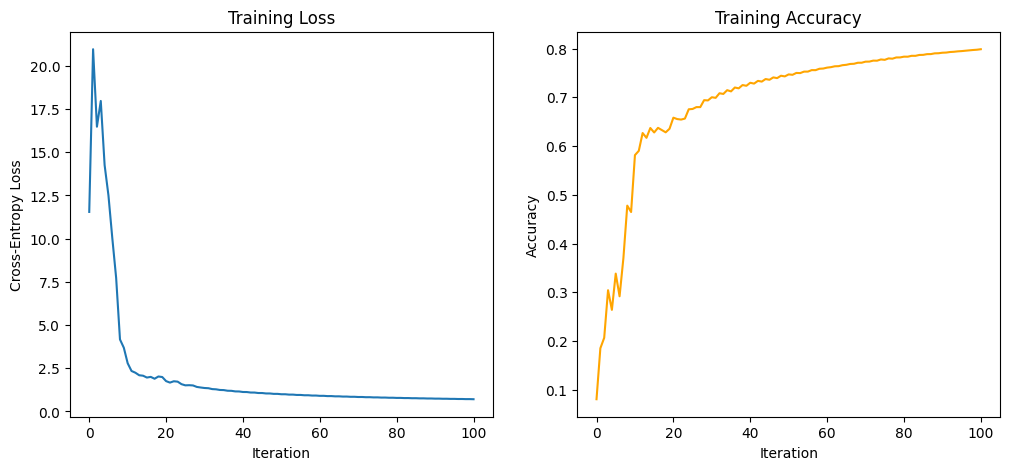

In [19]:
#Pipeline will be as following

#Create the NN class, which takes care of forward, backward, losss etc
nn = NeuralNetwork()

#Architecture
nn.linearLayer(784, 128, "RELU")
nn.linearLayer(128, 128, "RELU")
nn.linearLayer(128, 10, "Softmax")

loss_list = []
accuracy_list = []

# Forward pass for initial metrics
nn.Forward(X_flat)
loss_list.append(nn.returnLoss(y_train_onehot))
y_pred = np.argmax(nn.layers[-1].z, axis=1)
y_true = np.argmax(y_train_onehot, axis=1)
accuracy_list.append(np.mean(y_pred == y_true))

for i in range(100):
    # Compute gradients and update weights
    nn.backward(X_flat, y_train_onehot, lr=0.001)
    #debug
    #print("dW2 norm:", np.linalg.norm(nn.layers[-1].dW))


    # Recompute forward after weight update
    nn.Forward(X_flat)

    # Record metrics
    loss = nn.returnLoss(y_train_onehot)
    loss_list.append(loss)
    
    y_pred = np.argmax(nn.layers[-1].z, axis=1)
    acc = np.mean(y_pred == y_true)
    accuracy_list.append(acc)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_list)
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.subplot(1,2,2)
plt.plot(accuracy_list, color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()



___